In [377]:
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.set_printoptions(suppress=True)

In [112]:
def plot_by_epoch(points,name,per_100=False,p_type=None):
    x,y=zip(*points)
    if p_type:
        plt.semilogx(x,y,basex=2)
    else:
        plt.plot(x,y)
    plt.xlabel("Epoch")
    plt.ylabel("Coefficient")
    plt.title(name)

    ticks,_ = plt.yticks()
    if max(ticks)>=1000:
        plt.yticks(plt.yticks()[0],['{:,.0f}'.format(x) for x in plt.yticks()[0]])
    plt.show()
    
coef_scale = {'params':1e6}
    
def param_explore(dataset,p_min=None,p_max=None):
    preds = pkl.load(open(dataset,"rb"))
    points = []
    
    for key in list(preds.keys())[p_min:p_max]:
        points.append([key,preds[key]['b']])
    plot_by_epoch(points,"Intercept")    

    for param in range(len(preds[0]['m'])):
        points = []
        scale = coef_scale.get(param,1)
        for key in list(preds.keys())[p_min:p_max]:
            points.append([key,preds[key]['m'][param]])
            
        plot_by_epoch(points,preds[0]['coef_names'][param])
        
def log_explore(dataset):
    preds = pkl.load(open(dataset,"rb"))
    points = []
    
    for key in list(preds.keys()):
        points.append([key,preds[key]['b']])
    plot_by_epoch(points,"Intercept",p_type='log')    

    for param in range(len(preds[0]['m'])):
        points = []
        scale = coef_scale.get(preds[0]['coef_names'][param],1)
        for key in list(preds.keys()):
            points.append([key,scale*preds[key]['m'][param]])
        plot_by_epoch(points,preds[0]['coef_names'][param],p_type='log')
        x,y=zip(*points)
        print("Mean Value of {}: {:.2f}\n".format(preds[0]['coef_names'][param],np.mean(y[16:256])))

# Micro Preds

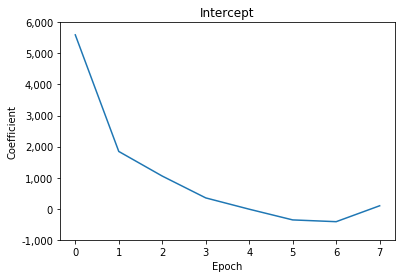

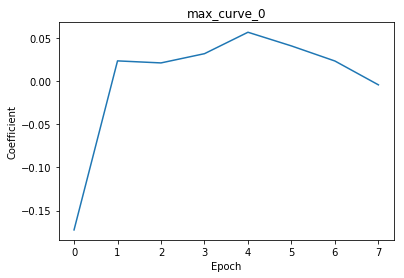

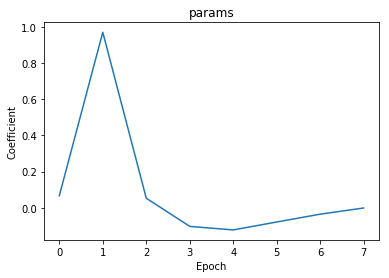

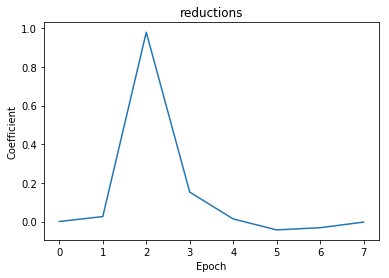

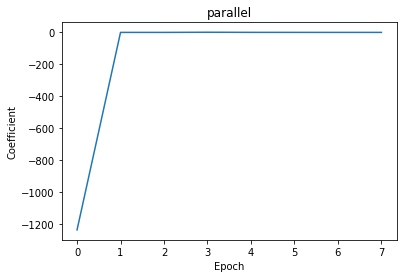

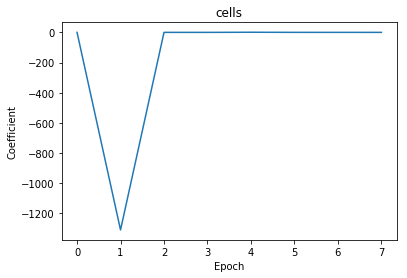

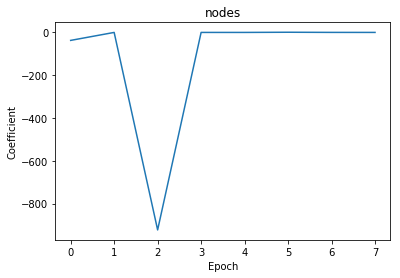

In [380]:
param_explore('micro_loss_predictors.pkl')

# Micro/Macro

In [5]:
pair_preds = pkl.load(open('pair_predictors.pkl',"rb"))

func_string = "{:.2f}".format(pair_preds['b'])

for param in range(len(pair_preds['m'])):
    func_string+="\n + {:<10.5f} * {}".format(
        pair_preds['m'][param],
        pair_preds['coef_names'][param])
print(func_string)

5785.97
 + -0.17530   * _score_micro
 + 0.00000    * macro_cells
 + 0.18011    * micro_params
 + -491.54079 * macro_cell_parallel
 + 94.87856   * nodes
 + 80448.72311 * macro_lr_max
 + 0.31949    * micro_delta


# Macro

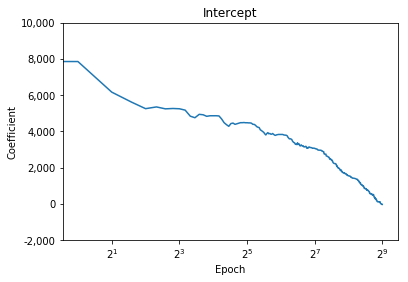

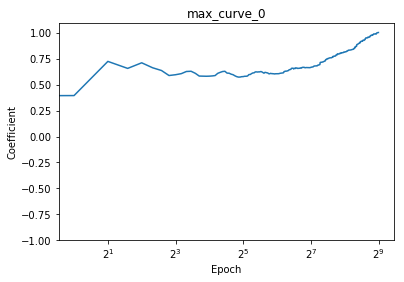

Mean Value of max_curve_0: 0.69



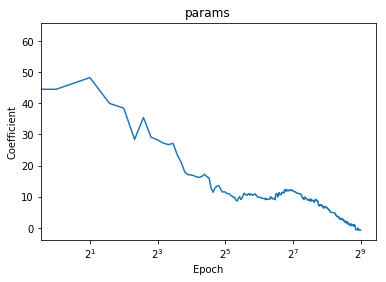

Mean Value of params: 9.94



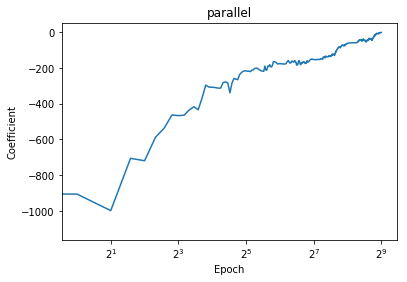

Mean Value of parallel: -150.01



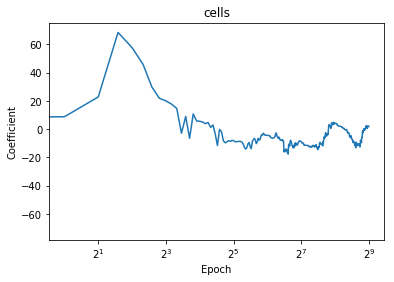

Mean Value of cells: -7.31



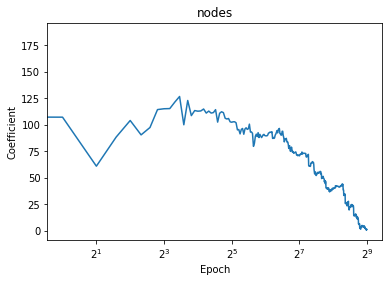

Mean Value of nodes: 70.95



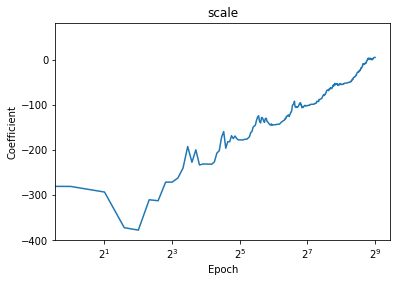

Mean Value of scale: -103.38



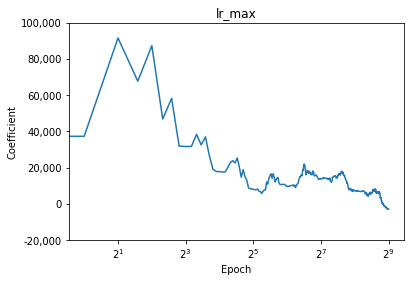

Mean Value of lr_max: 13312.55



In [113]:
log_explore('macro_loss_predictors.pkl') 

# Macro Lin Alg

9


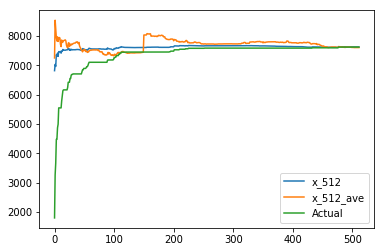

1M   params  : 13.437678495692325
1    parallel: -226.60972658076227
1    cells   : -5.920782751575858
1    nodes   : 89.71472774847882
1    scale   : -143.58246283673
.001 lr_max  : 17.28929385869402


In [412]:
preds = pkl.load(open('macro_loss_predictors.pkl',"rb"))

test_range = range(0,512)

X = pkl.load(open('macro_losses.pkl',"rb"))
i = np.random.randint(1,10)
print(i)
X = X[X['curve'].apply(lambda x: len(x)==512)].iloc[-i]

p = np.array(X[['params','parallel','cells','nodes','scale','lr_max']])
X_all = np.array(X[['max_curve_{}'.format(i) for i in range(512)]])
X = X_all[test_range]

C= []
for key in list(preds.keys()):
    C.append(preds[key]['b'])

betas = []
alphas = []
coef_names = []
for param in range(len(preds[0]['m'])):
    if 'max_curve' not in preds[0]['coef_names'][param]:
        points = []
        for key in list(preds.keys()):
            points.append(preds[key]['m'][param])
        betas.append(points)
        coef_names.append(preds[0]['coef_names'][param])
    else:
        for key in list(preds.keys()):
            alphas.append(preds[key]['m'][param])

#real values
C=np.array(C)[test_range]
betas=np.array(betas).T[test_range]
alphas=np.array(alphas)[test_range]

crossover = 150
betas_ave = np.mean(betas[:crossover],0)
x_512     = X*alphas+np.dot(betas,p)+C
x_512_ave = np.hstack([(X*alphas+np.dot(betas_ave,p) + C)[:crossover],(X*alphas+ C)[crossover:]])

plt.plot(test_range,x_512,label="x_512")
plt.plot(test_range,x_512_ave,label="x_512_ave")
plt.plot(X_all,label="Actual")
plt.legend()
plt.show()

for i,val in enumerate(betas_ave):
    name = coef_names[i]
    if name=='params':
        print("1M   {:<8}: {}".format(name,1e6*val))
    elif name=='lr_max':
        print(".001 {:<8}: {}".format(name,.001*val))
    else:
        print("1    {:<8}: {}".format(name,val))